In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 150,
    })

---
---
---

# BOXPLOT

In [2]:
df = pd.read_csv('10ma_FEAUTURES.csv')

X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((639, 8), (639,))

In [3]:
model_reglog = joblib.load('model_reglog.pkl')
model_svm = joblib.load('model_svm.pkl')
model_dtree = joblib.load('model_dtree.pkl')

In [4]:
#ACCURACY PRECISION RECACALL

In [5]:
df = {"valores": [], "modelo": [], "classe": [], "metrica": []}

for model in [model_reglog, model_svm, model_dtree]:
    for k in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=k*1)

        y_pred = model.predict(X_test)
        # Compute F1 score, precision, recall, and accuracy for each class separately
        precision = precision_score(y_test, y_pred, average=None)  # Precision for each class
        recall = recall_score(y_test, y_pred, average=None)  # Recall for each class
        accuracy = accuracy_score(y_test, y_pred)  # Accuracy (overall)

        classes = ["Low/Minimal", "Optimal", "Risk/Caution"]
        for classe in range(3):
            # precision
            df["valores"].append(precision[classe]*1)
            df["modelo"].append(str(model)[:3])
            df["classe"].append(classes[classe])
            df["metrica"].append("precision")

            # recall
            df["valores"].append(recall[classe]*1)
            df["modelo"].append(str(model)[:3])
            df["classe"].append(classes[classe])
            df["metrica"].append("recall")

        # accuracy
        df["valores"].append(accuracy*1)
        df["modelo"].append(str(model)[:3])
        df["classe"].append("Overall")
        df["metrica"].append("accuracy")

df = pd.DataFrame(df)
df.head(3)

,valores,modelo,classe,metrica
0,0.791667,Log,Low/Minimal,precision
1,0.678571,Log,Low/Minimal,recall
2,0.625000,Log,Optimal,precision


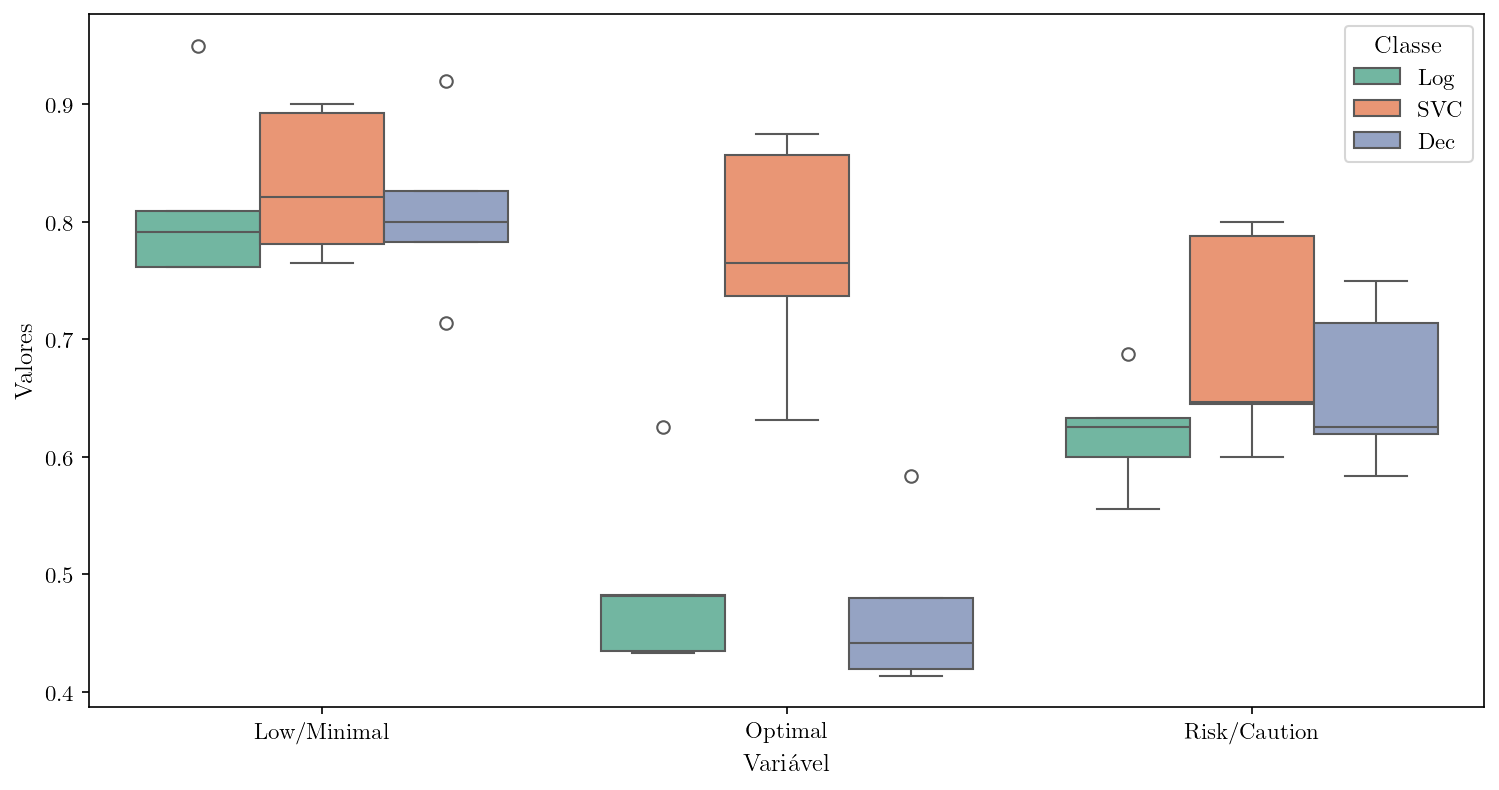

In [6]:


# Criar o gráfico de box plots agrupados
plt.figure(figsize=(12, 6))
sns.boxplot(x="classe", y="valores", hue="modelo", data=df[df["metrica"] == "precision"], palette="Set2")

# Adicionar título e rótulos
plt.xlabel("Variável")
plt.ylabel("Valores")

# Exibir o gráfico
plt.legend(title="Classe")
plt.show()


---
---
---

# PCA

In [7]:
df = pd.read_csv('10ma_FEAUTURES.csv')

X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train.shape, X_test.shape

((511, 8), (128, 8))

In [8]:
model_reglog = joblib.load('model_reglog.pkl')
model_svm = joblib.load('model_svm.pkl')
model_dtree = joblib.load('model_dtree.pkl')

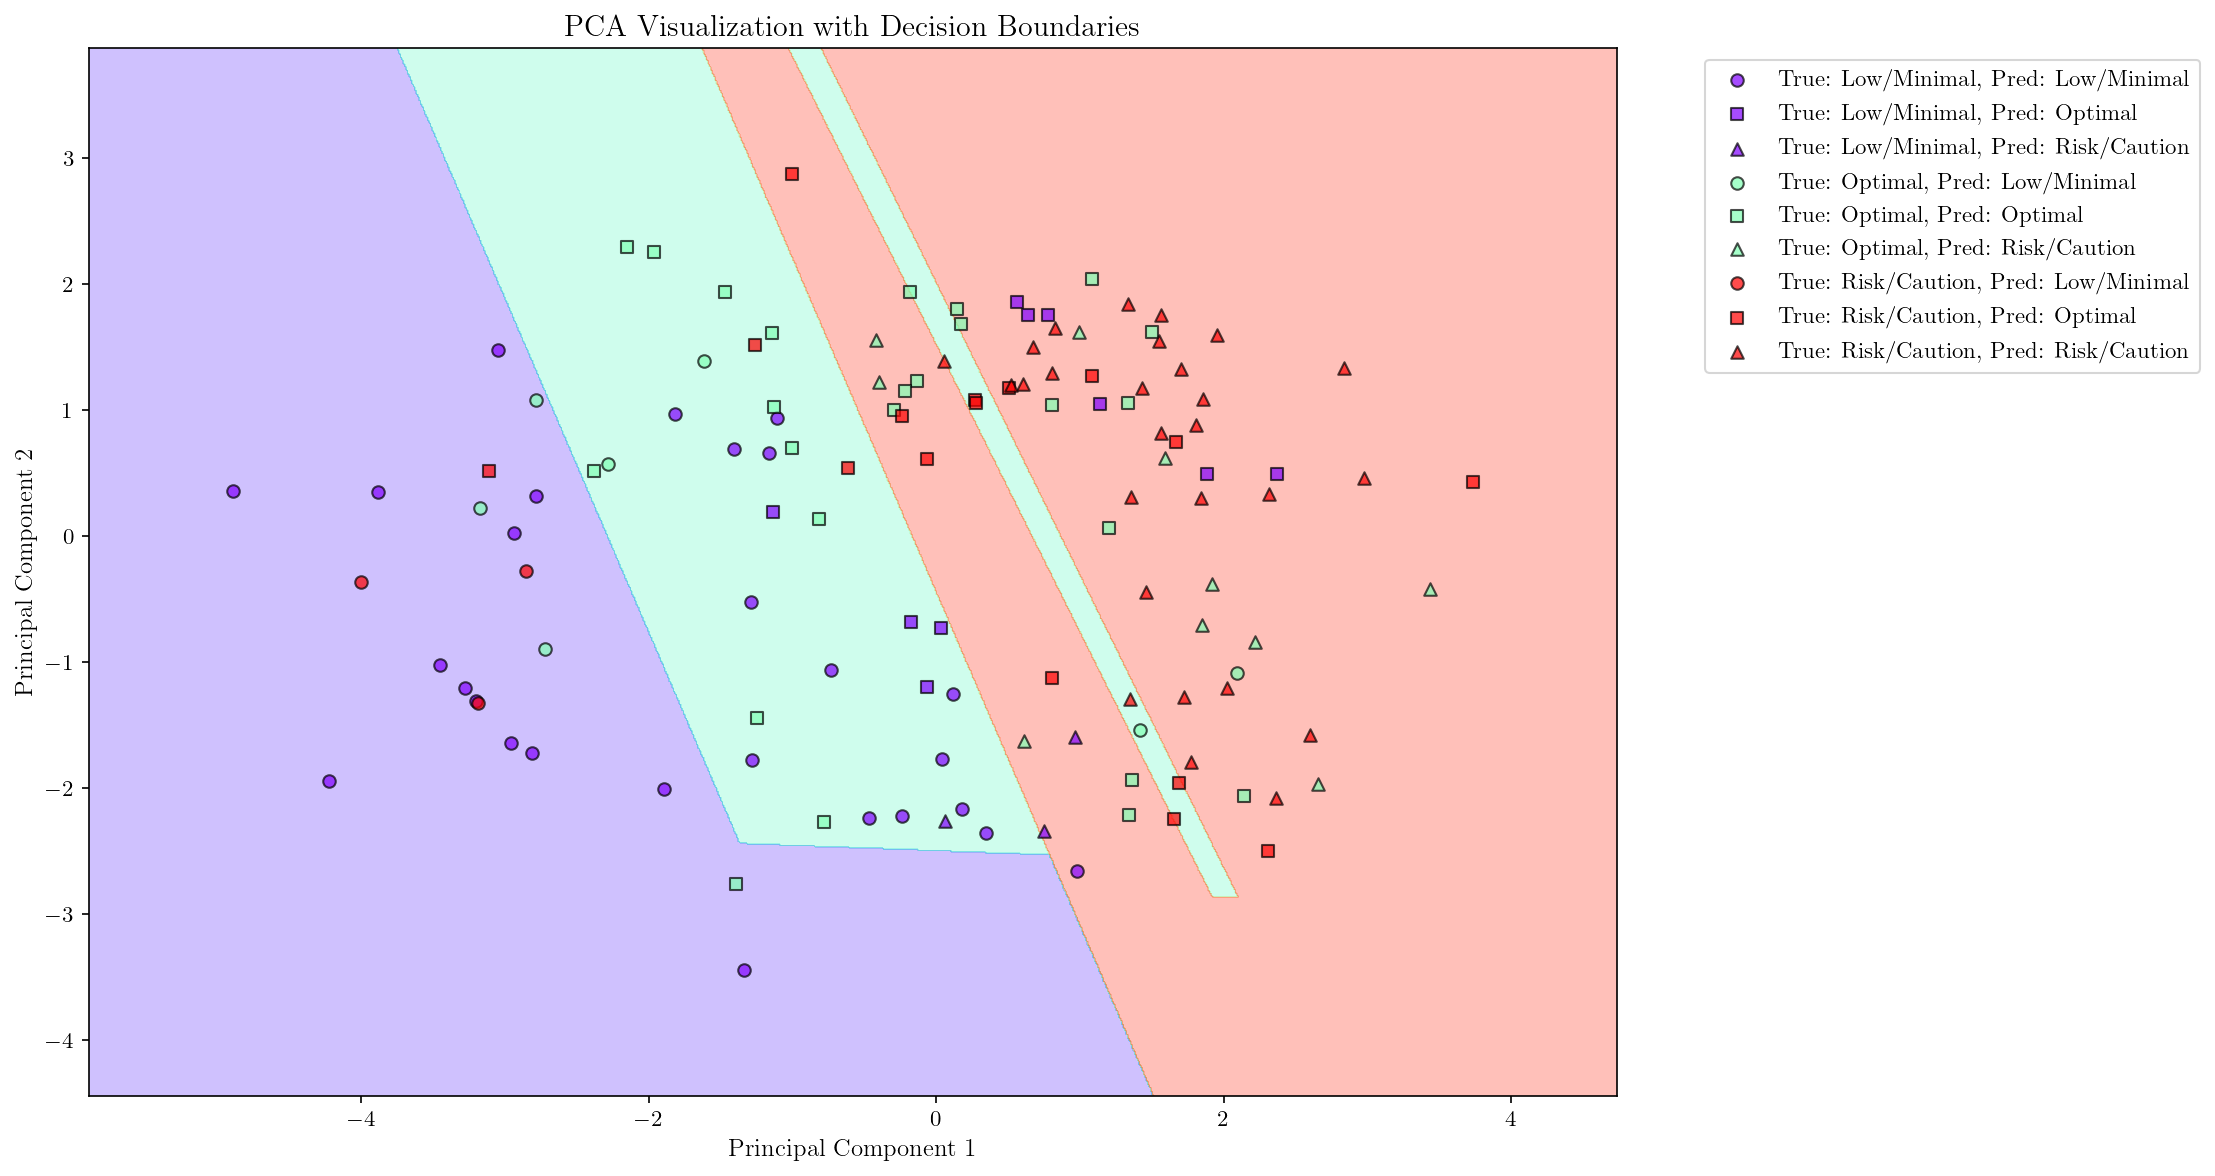

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import cm

MODEL = model_dtree

# Assuming you have the following:
# X: your features (numpy array or pandas DataFrame)
# y_class: true labels (array or series)
# y_pred: predicted labels from your models (array or series)
X = X_test
y_pred = MODEL.predict(X_test)
y_class = y_test

# Step 1: Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Prepare for plotting
# Assign unique colors to true labels
unique_classes = np.unique(y_class)
colors = cm.rainbow(np.linspace(0, 1, len(unique_classes)))
class_color_map = {cls: color for cls, color in zip(unique_classes, colors)}

# Assign unique markers to predicted labels
unique_predictions = np.unique(y_pred)
markers = ['o', 's', '^', 'D', 'P', '*'][:len(unique_predictions)]  # Adjust as needed
prediction_marker_map = {pred: marker for pred, marker in zip(unique_predictions, markers)}


# Step 1: Create a mesh grid in PCA space
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Step 2: Transform grid points back to the original feature space
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
grid_points_original = pca.inverse_transform(grid_points_pca)

# Step 3: Predict on the grid points
Z = MODEL.predict(grid_points_original)
Z = Z.reshape(xx.shape)
from sklearn.preprocessing import LabelEncoder

# Encode class labels into integers
encoder = LabelEncoder()
Z_numeric = encoder.fit_transform(Z.ravel())  # Flatten Z before encoding
Z_numeric = Z_numeric.reshape(xx.shape)  # Reshape back to match the grid

plt.figure(figsize=(15, 8))

# Step 4: Plot decision boundaries
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cm.rainbow)

# Overlay the original scatter plot
for true_class in unique_classes:
    for pred_class in unique_predictions:
        idx = (y_class == true_class) & (y_pred == pred_class)
        plt.scatter(
            X_pca[idx, 0], X_pca[idx, 1],
            c=[class_color_map[true_class]],
            marker=prediction_marker_map[pred_class],
            label=f"True: {true_class}, Pred: {pred_class}",
            edgecolor='k',
            alpha=0.7
        )

# Step 5: Finalize the plot
plt.title("PCA Visualization with Decision Boundaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
